In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent

from qiskit.extensions.unitary import UnitaryGate
from qiskit.circuit.library.standard_gates import CZGate
from qiskit.circuit.library.standard_gates import CRYGate
from qiskit.circuit.library.standard_gates import CHGate
from qiskit.circuit.library.standard_gates import HGate
from qiskit.circuit.library.standard_gates import XGate
from qiskit.circuit.library.standard_gates import RXGate
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.circuit.library.standard_gates import RZGate
from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [3]:
def rand_numb(low_in,high_in):
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

#just to keep the upper limit included in the random number generation. 

In [4]:
numLayer = 4
numQubit = 2
global iterations
global noisy

In [5]:
def Bx():
    temp = QuantumCircuit(2)
    temp.append(RXGate(-np.pi/2), [0])
    temp.append(RXGate(-np.pi/2), [1])
    return temp

In [6]:
def By():
    temp = QuantumCircuit(2)
    temp.append(RYGate(-np.pi/2), [0])
    temp.append(RYGate(-np.pi/2), [1])
    return temp

In [7]:
def Bz():
    temp = QuantumCircuit(2)
    temp.append(RZGate(-np.pi/2), [0])
    temp.append(RZGate(-np.pi/2), [1])
    return temp

In [8]:
def Bxb():
    temp = QuantumCircuit(2)
    temp.append(RXGate(np.pi/2), [0])
    temp.append(RXGate(np.pi/2), [1])
    return temp

In [9]:
def Byb():
    return By()

In [10]:
def Bzb():
    temp = QuantumCircuit(2)
    temp.append(RZGate(np.pi/2), [0])
    temp.append(RZGate(np.pi/2), [1])
    return temp

In [11]:
#Create unitaries here
#unitary_param_1 = np.array([])
#for i in range(0, 16):
#    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

unitary_param_1 = np.array([5.40530723, 0.30789834, 5.48565623, 5.49679285, 5.58904428, 3.67626375,
                            5.38444934, 0.19679063, 6.16917933, 0.2308673,  5.04796852, 6.02401649,
                            0.93282454, 4.6738944,  3.02576907, 2.90214658])

print(unitary_param_1)

[5.40530723 0.30789834 5.48565623 5.49679285 5.58904428 3.67626375
 5.38444934 0.19679063 6.16917933 0.2308673  5.04796852 6.02401649
 0.93282454 4.6738944  3.02576907 2.90214658]


In [12]:
def createProver(numQubit, numLayer):
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

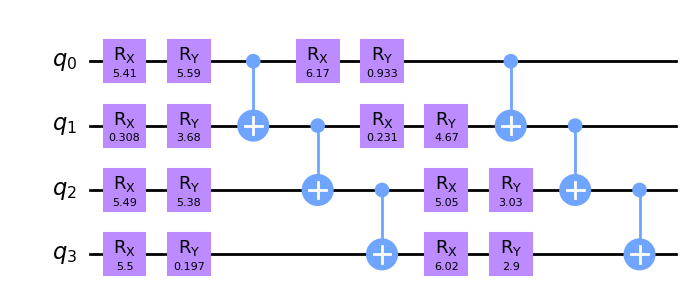

In [13]:
size = 4
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

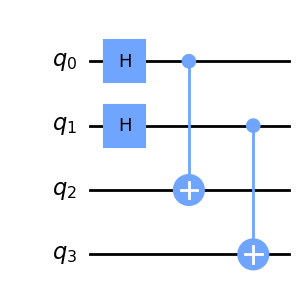

In [76]:
qcTest = QuantumCircuit(4)
qcTest.h(0)
qcTest.h(1)
qcTest.cx(0, 2)
qcTest.cx(1, 3)
qcTest.draw('mpl')

In [77]:
def createEqSuperposCollectiveU():
    temp = QuantumCircuit(5)
    
    temp.ry(2*np.arctan(1/np.sqrt(2)), 1)
    temp.x(1)
    temp.append(CHGate(), [1, 0])
    temp.x(1)
    
    temp.ry(np.pi/3, 2)
    temp.x(2)
    temp.append(CRYGate(2*np.arctan(1/np.sqrt(2))), [2, 3])
    temp.x(3)
    temp.append(HGate().control(2), [2, 3, 4])
    temp.x(2)
    temp.x(3)
    return temp

In [78]:
def createQuantumCircuit(state, numQubit, numLayer):
    circ = QuantumCircuit(9)
    #Create Quantum Circuit here
    
    superPosCircuit = createEqSuperposCollectiveU()
    circ.append(superPosCircuit, [0, 1, 2, 3, 4])
    circ.append(state, [5, 6, 7, 8])

    prover = createProver(numQubit, numLayer)
    circ.append(prover, [7, 8])
    
    circ.append(Bx().control(1), [4, 5, 6])
    circ.append(Bxb().control(1), [4, 7, 8])
    circ.append(Bx().control(1), [4, 5, 6])
    circ.append(Bxb().control(1), [4, 7, 8])
    
    circ.append(By().control(1), [3, 5, 6])
    circ.append(Byb().control(1), [3, 7, 8])
    circ.append(By().control(1), [3, 5, 6])
    circ.append(Byb().control(1), [3, 7, 8])

    circ.append(Bz().control(1), [2, 5, 6])
    circ.append(Bzb().control(1), [2, 7, 8])
    circ.append(Bz().control(1), [2, 5, 6])
    circ.append(Bzb().control(1), [2, 7, 8])
    
    circ.append(By().control(1), [1, 5, 6])
    circ.append(Byb().control(1), [1, 7, 8])
    circ.append(Bx().control(1), [1, 5, 6])
    circ.append(Bxb().control(1), [1, 7, 8])
    
    circ.append(Bx().control(1), [0, 5, 6])
    circ.append(Bxb().control(1), [0, 7, 8])
    circ.append(By().control(1), [0, 5, 6])
    circ.append(Byb().control(1), [0, 7, 8])

    circ.append(superPosCircuit.inverse(), range(5))
    
    return circ

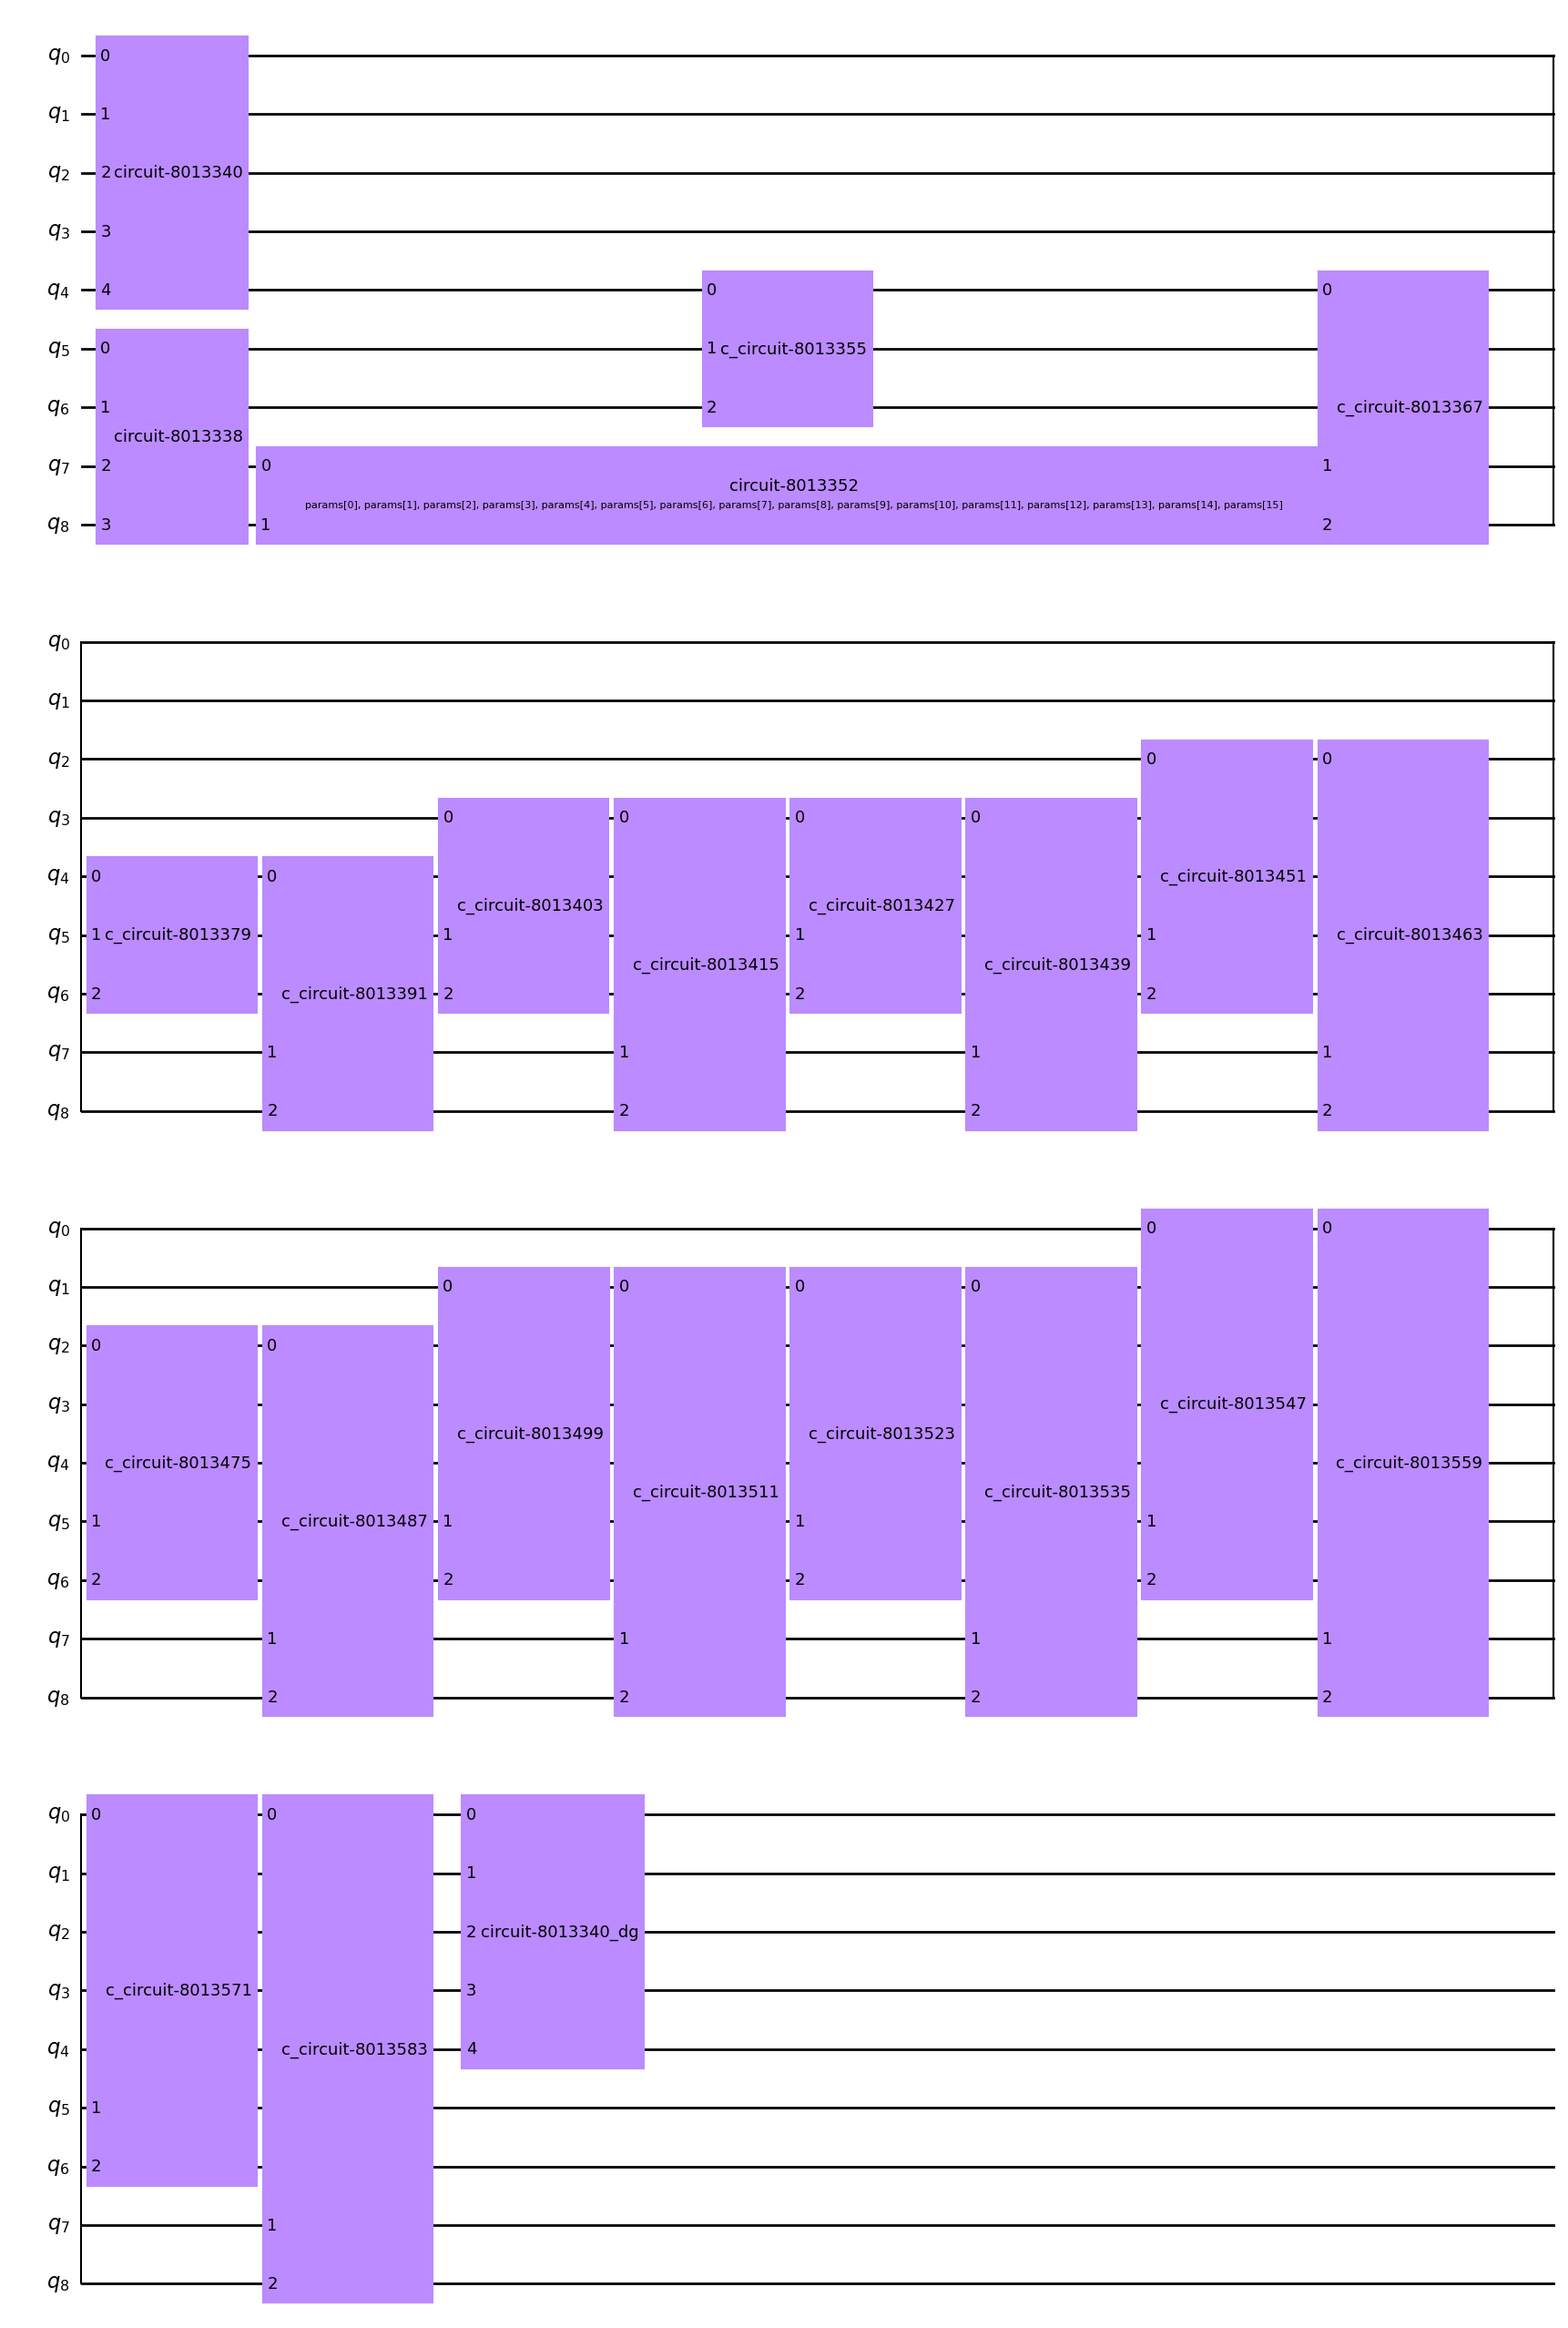

In [79]:
qCirc = createQuantumCircuit(qcTest, numQubit, numLayer)
qCirc.draw('mpl')

In [80]:
#use if noiseless
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [81]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation. 
'''
#Replace the provider with your personal credentials for hub, group and main
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")

noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [82]:
#Create Hamiltonian here
hamiltonian = I^I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [83]:
def costf(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [84]:
def gradient(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [85]:
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3]), ParameterVectorElement(params[4]), ParameterVectorElement(params[5]), ParameterVectorElement(params[6]), ParameterVectorElement(params[7]), ParameterVectorElement(params[8]), ParameterVectorElement(params[9]), ParameterVectorElement(params[10]), ParameterVectorElement(params[11]), ParameterVectorElement(params[12]), ParameterVectorElement(params[13]), ParameterVectorElement(params[14]), ParameterVectorElement(params[15])])


In [86]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [68]:
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[0.65858355 2.05621963 5.32771036 5.68860852 0.29515586 5.46257979
 1.75280066 1.10712364 4.03053585 5.44283041 4.96672822 5.35675956
 2.40524664 1.48314387 2.51502064 1.23165974]
Initial Cost :  0.39395762618001673


In [87]:
true_value = 1.0

In [88]:
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.08342843153278104
Loss Value :  0.08065905820478567 1.0%
Loss Value :  0.10950636029619712 2.0%
Loss Value :  0.13977119523227322 3.0%
Loss Value :  0.16898251347011722 4.0%
Loss Value :  0.17301107767785068 5.0%
Loss Value :  0.20330745916543566 6.0%
Loss Value :  0.20318144478074138 7.0%
Loss Value :  0.3712056025599871 8.0%
Loss Value :  0.3664266999667162 9.0%
Loss Value :  0.3452968194855025 10.0%
Loss Value :  0.3441528478534488 11.0%
Loss Value :  0.30256565545992054 12.0%
Loss Value :  0.27338980147387 13.0%
Loss Value :  0.2900514763450249 14.0%
Loss Value :  0.2844502565730396 15.0%
Loss Value :  0.26134262094448946 16.0%
Loss Value :  0.20095574088544138 17.0%
Loss Value :  0.21712700202928126 18.0%
Loss Value :  0.18704193671237018 19.0%
Loss Value :  0.224402576922542 20.0%
Loss Value :  0.2547787668327085 21.0%
Loss Value :  0.28034756263919786 22.0%
Loss Value :  0.3305517916535846 23.0%
Loss Value :  0.3300141129254621 24.0%
Loss Value :  0.29750524111

In [89]:
#noisy = True
#noisy_loss = []
#noisyParam = np.copy(paramProver)
#-1*costf(noisyParam)
#print("Initial Cost : ", -1*costf(noisyParam))
#autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
#x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

In [90]:
#noisy = False
#noiseResilientValue = -1*costf(x_opt)
#print(noiseResilientValue)

In [91]:
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
#print("Noisy : ", noisy_loss[-1])
#print("Noise Resilient Value : ", noiseResilientValue)

True Value :  1.0
Noiseless :  0.998837029732109


In [74]:
def writeToFile():
    file = open("CU_GS.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(true_value)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss[0:len(noiseless_loss)-1]]
    file.writelines(L)
    
    file.write(str(noiseless_loss[-1]))
    
    file.close()

In [75]:
writeToFile()